In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
# using_colab = False

In [3]:
# if using_colab:
#     import torch
#     import torchvision
#     print("PyTorch version:", torch.__version__)
#     print("Torchvision version:", torchvision.__version__)
#     print("CUDA is available:", torch.cuda.is_available())
#     import sys
#     !{sys.executable} -m pip install opencv-python matplotlib
#     !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

#     !mkdir -p images
#     !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

#     !mkdir -p ../checkpoints/
#     !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [12]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.9), thickness=1) 

    ax.imshow(img)

## Example image

In [30]:
image = Image.open('C:/Users/coldbrew/VTON-project/data/renamed/renamed_cloth_images/womanc00.jpg')
# 사람 이미지는 resize_and_crop 함수로, 옷 이미지는 resize_and_padding 함수로 크기 조정
import sys, os
current_dir = os.getcwd()
project_root_dir = os.path.abspath(os.path.join(current_dir, ".."))
catvton_dir = os.path.join(project_root_dir, "CatVTON")

if catvton_dir not in sys.path:
    sys.path.insert(0, catvton_dir)
    
from utils import resize_and_crop
img = resize_and_crop(image, (1024, 768))
img = img.rotate(270, expand=True)
image = np.array(img.convert("RGB"))


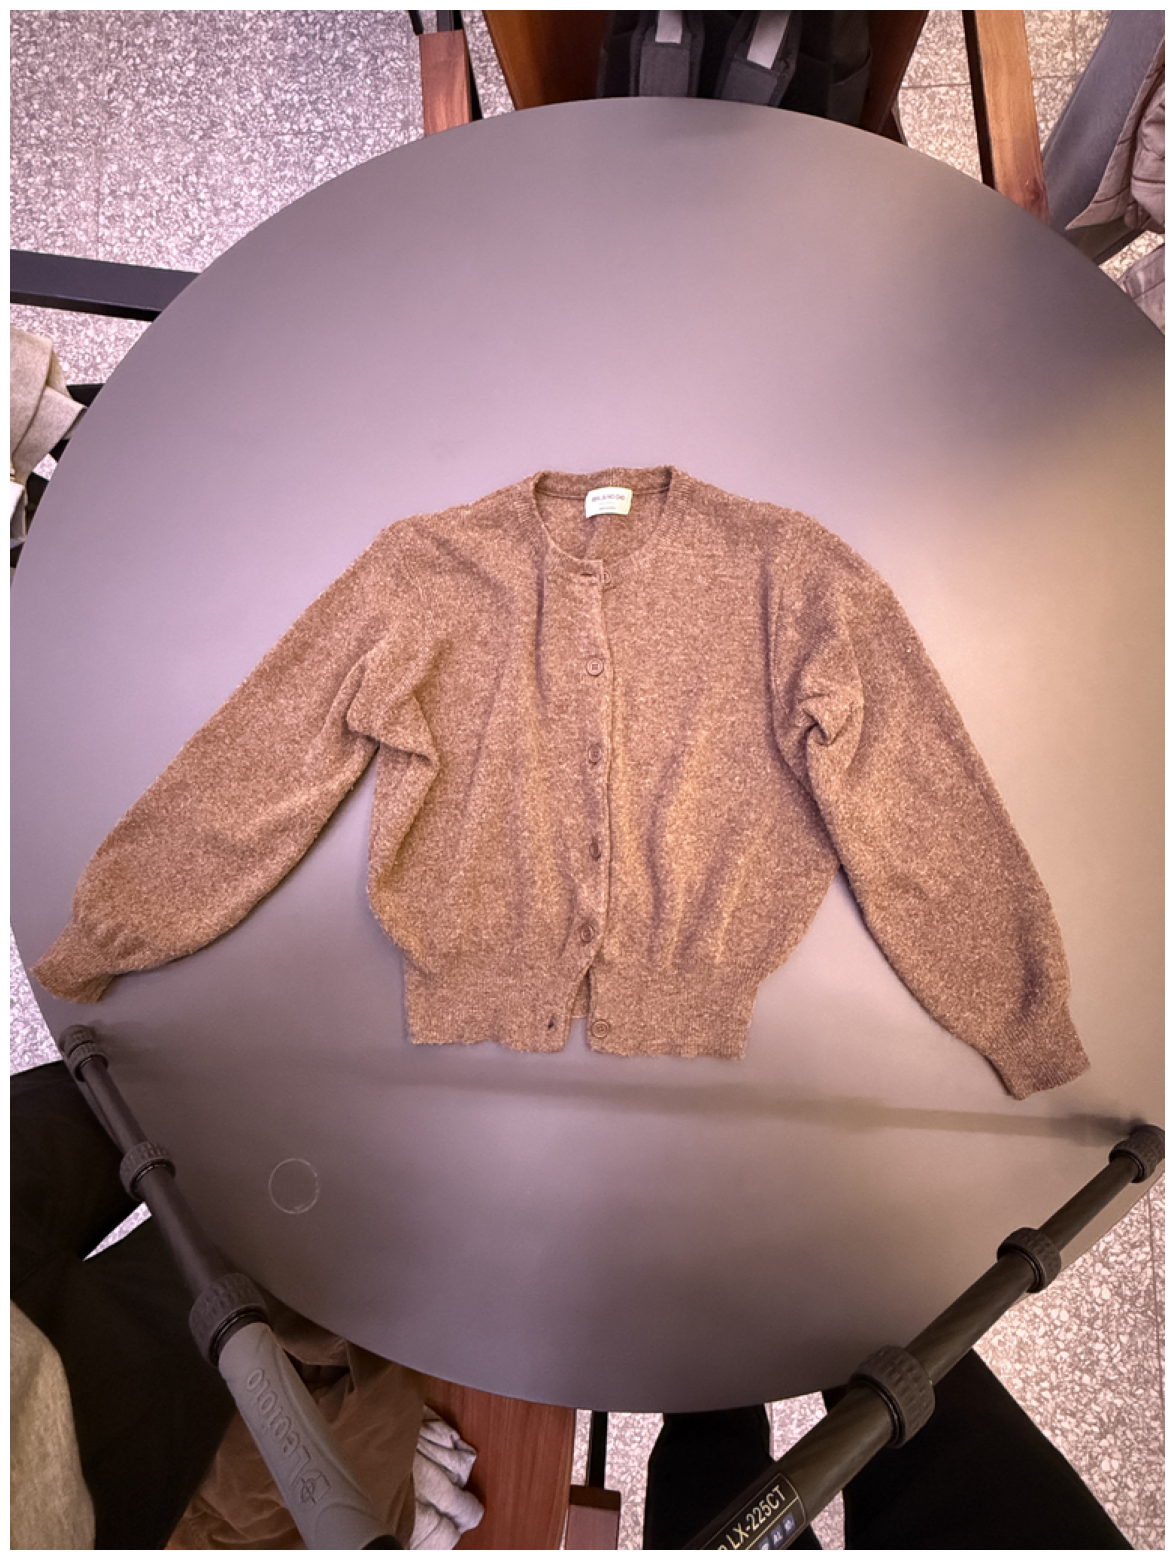

In [31]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [32]:
import sys, os
project_root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sam_root = os.path.join(project_root_dir,"sam2")
sys.path.insert(0, sam_root)

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = os.path.join(sam_root,"checkpoints\sam2.1_hiera_s.yaml")
# model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_checkpoint = os.path.join(sam_root,"checkpoints\sam2.1_hiera_small.pt")
# predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

sam2 = build_sam2(model_cfg, sam2_checkpoint, device="cuda", apply_postprocessing=True)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

To generate masks, just run `generate` on an image.

In [33]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [34]:
print(len(masks))
print(masks[0].keys())

33
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

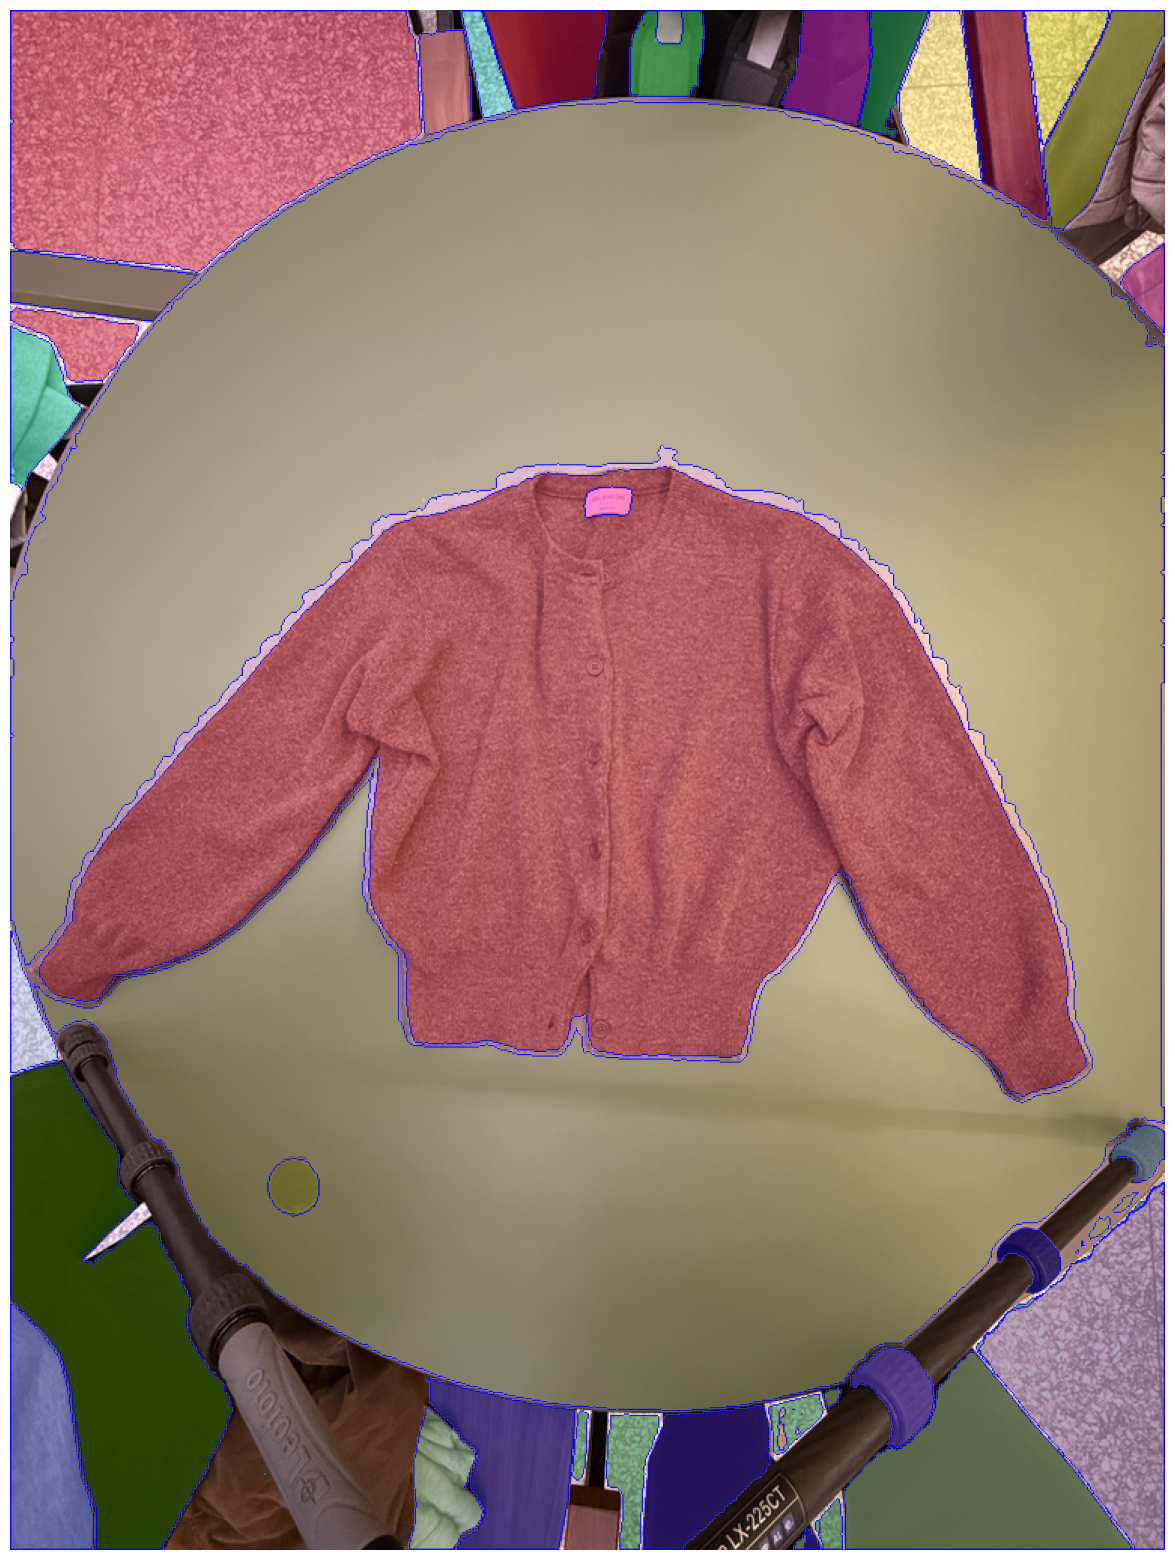

In [35]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## 중앙 탐색 버전

이미지 크기: 768 1024
이미지 중심: 384 712


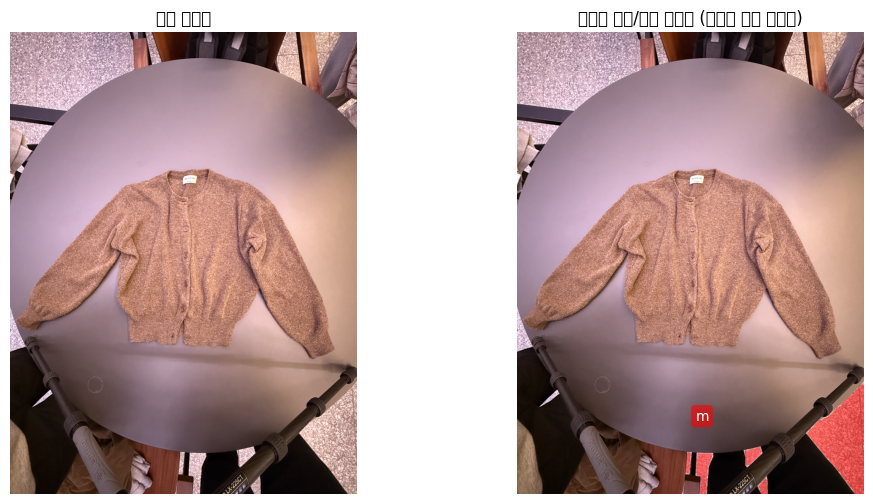

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# 원본 이미지 크기
img_h, img_w = image.shape[:2]
center_x, center_y = img_w // 2, img_h // 2 + 200 # 이미지 중심 좌표
print("이미지 크기:", img_w, img_h)
print("이미지 중심:", center_x, center_y)

# 가장 중앙에 가까운 마스크 찾기
best_mask = None
min_distance = float("inf")  # 최소 거리 (중앙과의 거리)

for mask in masks:
    x, y, w, h = mask['bbox']

    # BBox 중심 좌표 계산
    mask_center_x, mask_center_y = x + w // 2, y + h // 2

    # 이미지 중심과의 거리 계산 (유클리드 거리)
    distance = np.sqrt((mask_center_x - center_x) ** 2 + (mask_center_y - center_y) ** 2)

    # 현재까지의 최소 거리보다 작은 경우 선택
    if distance < min_distance:
        best_mask = mask
        min_distance = distance

# 마스크가 없으면 종료
if best_mask is None:
    print("⚠️ 중앙에 가장 가까운 마스크(상의/바지)를 찾을 수 없습니다.")
else:
    # 선택된 마스크 오버레이
    overlay = image.copy()
    segmentation = best_mask['segmentation']
    color = np.array([255, 0, 0])  # 빨간색

    # 마스크 색상 적용 (반투명)
    overlay[segmentation] = (
        0.5 * overlay[segmentation] + 0.5 * color
    ).astype(np.uint8)

    # 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # 원본 이미지 출력
    ax[0].imshow(image)
    ax[0].set_title("원본 이미지")
    ax[0].axis("off")

    # 선택된 마스크 (상의 또는 바지) 출력
    ax[1].imshow(overlay)
    ax[1].set_title("선택된 상의/바지 마스크 (중앙에 가장 가까운)")
    ax[1].axis("off")

    # bbox 중심에 라벨 추가
    x, y, w, h = best_mask['bbox']
    mask_center_x, mask_center_y = x + w // 2, y + h // 2

    ax[1].text(
        mask_center_x, mask_center_y, "m",
        color="white", fontsize=10,
        bbox=dict(facecolor="red", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    )

    plt.show()

## 중앙 박스 탐색 버전

중앙 기준 박스: X(307~460), Y(409~512)


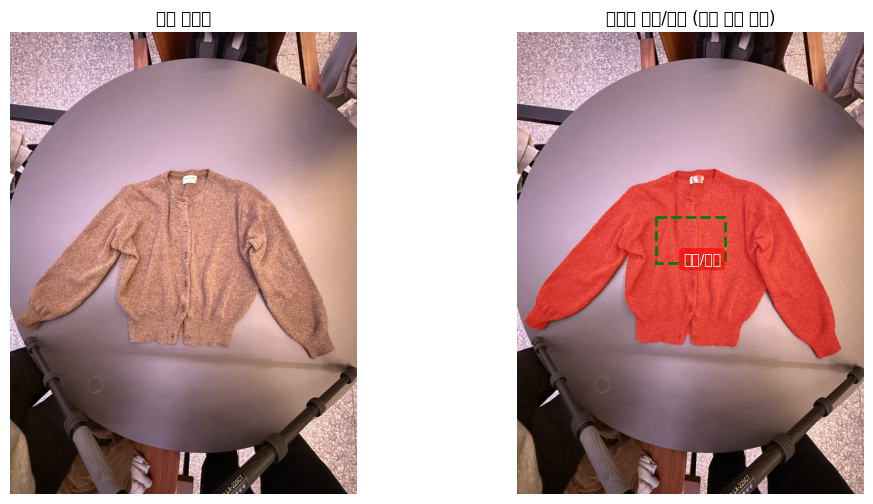

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 원본 이미지 크기
img_h, img_w = image.shape[:2]
x_min, x_max = int(img_w * 0.4), int(img_w * 0.6)  # 이미지 가로 40~60%
y_min, y_max = int(img_h * 0.4), int(img_h * 0.5)  # 이미지 세로 40~60%
print(f"중앙 기준 박스: X({x_min}~{x_max}), Y({y_min}~{y_max})")

# 박스 안에 가장 많이 포함되는 마스크 찾기
best_mask = None
max_overlap = 0

for mask in masks:
    x, y, w, h = mask['bbox']
    
    # 마스크의 좌표 (bbox)
    mask_x_min, mask_x_max = x, x + w
    mask_y_min, mask_y_max = y, y + h
    
    # 중앙 박스와의 겹치는 부분 계산
    overlap_x_min = max(x_min, mask_x_min)
    overlap_x_max = min(x_max, mask_x_max)
    overlap_y_min = max(y_min, mask_y_min)
    overlap_y_max = min(y_max, mask_y_max)
    
    # 겹치는 영역의 크기 계산
    overlap_width = max(0, overlap_x_max - overlap_x_min)
    overlap_height = max(0, overlap_y_max - overlap_y_min)
    overlap_area = overlap_width * overlap_height
    
    # 가장 많이 겹치는 마스크 선택
    if overlap_area > max_overlap:
        best_mask = mask
        max_overlap = overlap_area

# 마스크가 없으면 종료
if best_mask is None:
    print("⚠️ 중앙 박스 안에 포함되는 마스크(상의/바지)를 찾을 수 없습니다.")
else:
    # 선택된 마스크 오버레이
    overlay = image.copy()
    segmentation = best_mask['segmentation']
    color = np.array([255, 0, 0])  # 빨간색

    # 마스크 색상 적용 (반투명)
    overlay[segmentation] = (
        0.5 * overlay[segmentation] + 0.5 * color
    ).astype(np.uint8)

    # 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # 원본 이미지 출력
    ax[0].imshow(image)
    ax[0].set_title("원본 이미지")
    ax[0].axis("off")

    # 선택된 마스크 (상의 또는 바지) 출력
    ax[1].imshow(overlay)
    
    # 중앙 기준 박스 시각화
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=2, edgecolor='green', facecolor='none', linestyle='dashed')
    ax[1].add_patch(rect)
    
    ax[1].set_title("선택된 상의/바지 (중앙 박스 기준)")
    ax[1].axis("off")

    # bbox 중심에 라벨 추가
    x, y, w, h = best_mask['bbox']
    mask_center_x, mask_center_y = x + w // 2, y + h // 2

    ax[1].text(
        mask_center_x, mask_center_y, "상의/바지",
        color="white", fontsize=10,
        bbox=dict(facecolor="red", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    )

    plt.show()

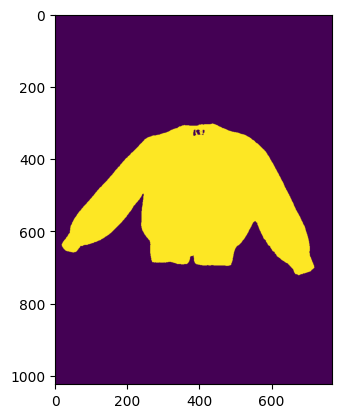

In [38]:
plt.imshow(segmentation)

In [41]:
for i, mask in enumerate(masks[:5]):  # 처음 5개의 마스크만 확인
    print(f"Mask {i}:")
    print(f" - Bounding Box: {mask['bbox']}")
    print(f" - Stability Score: {mask['stability_score']:.4f}")
    print(f" - Predicted IoU: {mask['predicted_iou']:.4f}")
    print("-" * 40)

Mask 0:
 - Bounding Box: [0.0, 851.0, 43.0, 172.0]
 - Stability Score: 0.9894
 - Predicted IoU: 0.9844
----------------------------------------
Mask 1:
 - Bounding Box: [0.0, 0.0, 273.0, 247.0]
 - Stability Score: 0.9737
 - Predicted IoU: 0.9805
----------------------------------------
Mask 2:
 - Bounding Box: [205.0, 129.0, 390.0, 791.0]
 - Stability Score: 0.9593
 - Predicted IoU: 0.9805
----------------------------------------
Mask 3:
 - Bounding Box: [0.0, 0.0, 273.0, 655.0]
 - Stability Score: 0.9555
 - Predicted IoU: 0.9766
----------------------------------------
Mask 4:
 - Bounding Box: [676.0, 0.0, 91.0, 207.0]
 - Stability Score: 0.9857
 - Predicted IoU: 0.9766
----------------------------------------


## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [42]:
# mask_generator_2 = SAM2AutomaticMaskGenerator(
#     model=sam2,
#     points_per_side=64,
#     points_per_batch=128,
#     pred_iou_thresh=0.7,
#     stability_score_thresh=0.92,
#     stability_score_offset=0.7,
#     crop_n_layers=1,
#     box_nms_thresh=0.7,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=25.0,
#     use_m2m=True,
# )

In [43]:
# masks2 = mask_generator_2.generate(image)

In [44]:
# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# show_anns(masks2)
# plt.axis('off')
# plt.show() 